# Book Recommender System

We import the necessary libraries for the task 

In [46]:
import pandas as pd
import numpy as np
from scipy import sparse
from pandas.api.types import CategoricalDtype
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

The Book-Crossing dataset comprises 3 files.

Users
- Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.

Books
- Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

Ratings
- Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [3]:
books_dataset= pd.read_csv("datasets/Books.csv", sep=",")
ratings_dataset= pd.read_csv("datasets/Ratings.csv", sep=",")
users_dataset= pd.read_csv("datasets/Users.csv", sep=",")

C:\Users\vladi\AppData\Local\Temp\ipykernel_7416\42244209.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_dataset= pd.read_csv("datasets/Books.csv", sep=",")


## Exploratory data analysis

### Show description of datasets

In [4]:
books_dataset.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [5]:
ratings_dataset.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [6]:
users_dataset.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [24]:
len(users_dataset["User-ID"].unique())

278858

In [25]:
users_dataset.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### See if there are null values on the data 

Text(0.5, 1.0, 'null values on books Dataset')

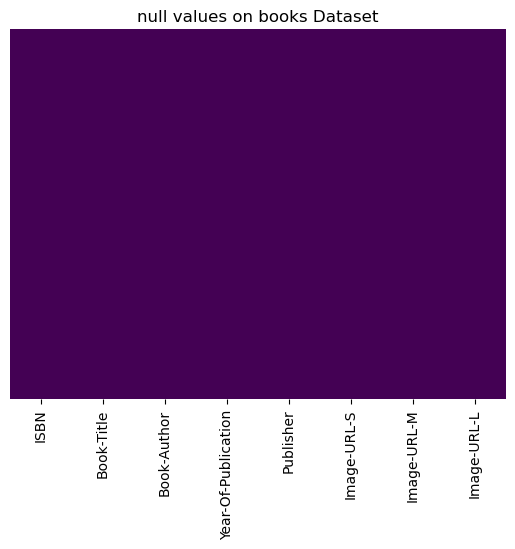

In [13]:
sns.heatmap(books_dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis').set_title('null values on books Dataset')

Text(0.5, 1.0, 'null values on ratings Dataset')

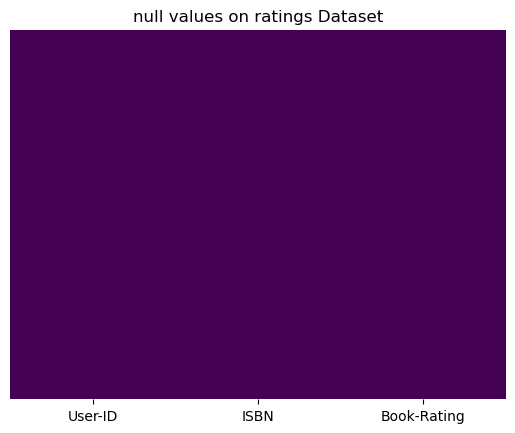

In [17]:
sns.heatmap(ratings_dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis').set_title('null values on ratings Dataset')

Text(0.5, 1.0, 'null values on users Dataset')

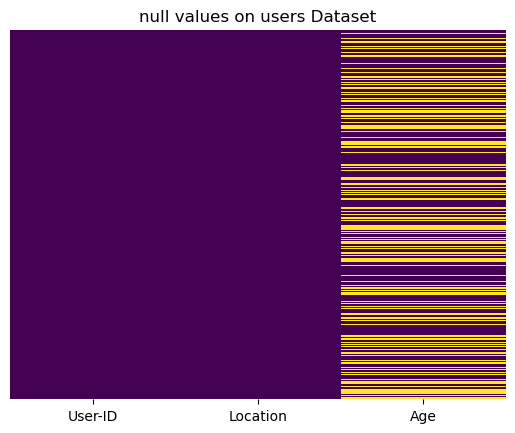

In [16]:
sns.heatmap(users_dataset.isnull(),yticklabels=False,cbar=False,cmap='viridis').set_title('null values on users Dataset')

As we can see, we have several null values on the Age column inside the users dataset. This is fine since we are not using that column for building the recommendation system. 

## Recommender System building 

### Content-based recommender system 

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.

We need to merge the books with the user dataset in order to begin constructing the user-item sparse matrix

In [52]:
books_merge = pd.merge(ratings_dataset, books_dataset, on='ISBN').drop(["Image-URL-M", "Image-URL-L", "Image-URL-S"], axis=1)
books_merge.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


In [53]:
users = books_merge["User-ID"].unique()
books = books_merge["ISBN"].unique()
shape = (len(users), len(books))

In [54]:
print("Number of users that reviewed books", len(users))
print("Number of books reviewed", len(books))

Number of users that reviewed books 92106
Number of books reviewed 270151


Look for the books who reviewed more than 200 users

In [55]:
workcount = books_merge[["ISBN","User-ID"]].groupby("ISBN").count()
workcount = workcount[workcount["User-ID"] >= 200]
print(workcount.head()) 

            User-ID
ISBN               
0060392452      283
0060502258      376
0060915544      244
0060928336      732
0060930535      494


Look for the users who reviewed more than 50 books

In [56]:
usercount = books_merge[["ISBN","User-ID"]].groupby("User-ID").count()
usercount = usercount[usercount["ISBN"] >= 50]
print(usercount.head())

         ISBN
User-ID      
243        79
254       300
507       129
638        73
643        56


In [57]:
reviews = books_merge[books_merge["User-ID"].isin(usercount.index) & books_merge["ISBN"].isin(workcount.index)]

In [58]:
reviews

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
1381,3675,0451166892,0,The Pillars of the Earth,Ken Follett,1996,Signet Book
1384,8019,0451166892,0,The Pillars of the Earth,Ken Follett,1996,Signet Book
1386,11629,0451166892,8,The Pillars of the Earth,Ken Follett,1996,Signet Book
1387,11676,0451166892,0,The Pillars of the Earth,Ken Follett,1996,Signet Book
1388,13582,0451166892,0,The Pillars of the Earth,Ken Follett,1996,Signet Book
...,...,...,...,...,...,...,...
352769,263877,0440212561,0,Outlander,DIANA GABALDON,1992,Dell
352772,269890,0440212561,6,Outlander,DIANA GABALDON,1992,Dell
352773,270713,0440212561,0,Outlander,DIANA GABALDON,1992,Dell
352774,275970,0440212561,0,Outlander,DIANA GABALDON,1992,Dell


In [59]:
reviews.describe()

,User-ID,Book-Rating
count,34733.000000,34733.000000
mean,139413.545936,2.527884
std,80810.399796,3.838103
min,243.000000,0.000000
25%,69232.000000,0.000000
50%,137688.000000,0.000000
75%,211426.000000,7.000000
max,278843.000000,10.000000


In [60]:
reviewmatrix = reviews.pivot(index="ISBN", columns="User-ID", values="Book-Rating").fillna(0)

In [61]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_scores = cosine_similarity(reviewmatrix)
similarity_scores.shape

(194, 194)

In [62]:
similarity_scores

array([[1.        , 0.02702304, 0.05715617, ..., 0.        , 0.        ,
        0.03945255],
       [0.02702304, 1.        , 0.        , ..., 0.05991277, 0.0382255 ,
        0.04458922],
       [0.05715617, 0.        , 1.        , ..., 0.06498049, 0.01577568,
        0.        ],
       ...,
       [0.        , 0.05991277, 0.06498049, ..., 1.        , 0.        ,
        0.02227148],
       [0.        , 0.0382255 , 0.01577568, ..., 0.        , 1.        ,
        0.04085269],
       [0.03945255, 0.04458922, 0.        , ..., 0.02227148, 0.04085269,
        1.        ]])

In [72]:
def recommend(book_name):
    #index fetch
    index = np.where(reviewmatrix.index==book_name)[0][0]
    #distances = similarity_scores[index]
    similar_items = sorted(list(enumerate(similarity_scores[index])), key=lambda x:x[1], reverse=True)[1:6]
    for i in similar_items:
        print(reviewmatrix.index[i[0]], ":", books_merge[books_merge["ISBN"]==reviewmatrix.index[i[0]]]["Book-Title"].iloc[0])
    #return suggestions

recommend("043935806X")

059035342X : Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
0439136369 : Harry Potter and the Prisoner of Azkaban (Book 3)
0439064872 : Harry Potter and the Chamber of Secrets (Book 2)
0064407667 : The Bad Beginning (A Series of Unfortunate Events, Book 1)
0316769487 : The Catcher in the Rye


## Model based Recommendation System

Singular value decomposition is a very popular linear algebra technique to break down a matrix into the product of a few smaller matrices. In fact, it is a technique that has many uses. One example is that we can use SVD to discover relationship between items. A recommender system can be build easily from this.

In [35]:
minimum_rating = min(books_merge['Book-Rating'].values)
maximum_rating = max(books_merge['Book-Rating'].values)

In [36]:
minimum_rating

0

In [37]:
maximum_rating


10

In [39]:
reader = Reader(rating_scale=(minimum_rating, maximum_rating))
data = Dataset.load_from_df(books_merge[['User-ID', 'ISBN', 'Book-Rating']], reader)

Imagine we collected some book reviews such that books are columns and people are rows, and the entries are the ratings that a person gave to a book. In that case,  would be a table of person-to-person which the entries would mean the sum of the ratings one person gave match with another one. Similarly  would be a table of book-to-book which entries are the sum of the ratings received match with that received by another book. What can be the hidden connection between people and books? That could be the genre, or the author, or something of similar nature.

In [42]:
svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    3.4580  3.4563  3.4535  3.4602  3.4527  3.4554  3.4535  3.4456  3.4611  3.4531  3.4549  0.0042  
MAE (testset)     2.7889  2.7908  2.7904  2.7911  2.7885  2.7837  2.7882  2.7802  2.7950  2.7886  2.7885  0.0039  
Fit time          9.40    10.02   10.08   10.21   10.13   10.32   11.55   11.20   10.85   10.68   10.44   0.60    
Test time         1.40    0.81    0.81    0.81    1.43    0.82    0.89    1.46    0.93    0.95    1.03    0.27    


In [44]:
print("Average MAE: ", np.average(results["test_mae"]))
print("Average RMSE: ", np.average(results["test_rmse"]))

Average MAE:  2.788539949337383
Average RMSE:  3.454944408026401


In [45]:
param_grid = {
  'n_factors': [20, 50, 100],
  'n_epochs': [5, 10, 20]
}
 
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)
 
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

3.41810298604499
{'n_factors': 20, 'n_epochs': 5}


In [47]:
# best hyperparameters
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']
 
# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=.20)
 
# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)
 
# Train the algorithm on the trainset
svd.fit(trainset)

In [51]:
def generate_recommendation(model, user_id, books_merge, n_items):
   # Get a list of all movie IDs from dataset
   books_ids =  books_merge["ISBN"].unique()
 
   # Get a list of all movie IDs that have been watched by user
   books_ids_user = books_merge.loc[ books_merge["User-ID"] == user_id, "ISBN"]
    # Get a list off all movie IDS that that have not been watched by user
   movie_ids_to_pred = np.setdiff1d(books_ids, books_ids_user)
 
   # Apply a rating of 4 to all interactions (only to match the Surprise dataset format)
   test_set = [[user_id, movie_id, 4] for movie_id in movie_ids_to_pred]
 
   # Predict the ratings and generate recommendations
   predictions = model.test(test_set)
   pred_ratings = np.array([pred.est for pred in predictions])
   print("Top {0} item recommendations for user {1}:".format(n_items, user_id))
   # Rank top-n movies based on the predicted ratings
   index_max = (-pred_ratings).argsort()[:n_items]
   for i in index_max:
       movie_id = movie_ids_to_pred[i]
       print(books_merge[books_merge["ISBN"]==movie_id]["Book-Title"].values[0], pred_ratings[i])
 
 
# define which user ID that we want to give recommendation
userID = 276939
# define how many top-n movies that we want to recommend
n_items = 10
# generate recommendation using the model that we have trained
generate_recommendation(svd,userID,books_merge,n_items)

Top 10 item recommendations for user 276939:
Free 6.34179362157296
The Lovely Bones: A Novel 6.139482196116683
Harry Potter and the Goblet of Fire (Book 4) 6.0694593999881015
Harry Potter and the Prisoner of Azkaban (Book 3) 6.0395173684029695
Harry Potter and the Sorcerer's Stone (Book 1) 6.001501561252589
Harry Potter and the Chamber of Secrets (Book 2) 5.913136082575046
Ender's Game (Ender Wiggins Saga (Paperback)) 5.758473201518409
To Kill a Mockingbird 5.737388776628223
Harry Potter and the Order of the Phoenix (Book 5) 5.623799395684434
The Little Prince 5.549273723252941
